In [1]:
import os
# Move to Thesis directory (two levels up)
os.chdir(os.path.abspath(os.path.join("..", "..")))

# Move to model/src if it exists
model_dir = os.path.join(os.getcwd(), "model", "src")
if os.path.exists(model_dir):
    os.chdir(model_dir)

print("Current Directory:", os.getcwd())

Current Directory: c:\Users\1176153\Downloads\github\Thesis\model\src


In [2]:
from libs import data_handeling as dh
from libs.settings import data_catalog as dc
from langchain.vectorstores import Chroma

In [44]:
documents_chunked = dh.load_documents_from_pickle(dc.DOCUMENTS_CHUNKED)
documents_chunked

✅ Loaded 1017 documents from ..\..\data\Preprocessing_text\all_programs_chunked\docs_all_programs_chunked_without_metadata.pkl


[Document(metadata={'source': 'bachelor_data-science_teaching-staff_text.txt', 'degree': 'bachelor', 'doc_type': 'teaching_staff', 'course_name': 'Data Science'}, page_content="Teaching Staff en Programs Bachelor's\nDegrees Data Science Teaching Staff Américo Rio Invited Assistant Professor\namerico.rio@novaims.unl.pt\n\nAna Cristina\nCosta Associate Professor\ncristina@novaims.unl.pt\n\nArtur Varanda\nAdjunct Lecturer\navaranda@novaims.unl.pt\n\nAugusto Santos\nAssistant Professor\najrsantos@novaims.unl.pt\n\nBruno Damásio\nAssistant Professor\nbdamasio@novaims.unl.pt\n\nCarina Albuquerque\nAssistant Professor\ncalbuquerque@novaims.unl.pt\n\nCarolina Maria\nShaul Adjunct Lecturer\ncshaul@novaims.unl.pt\n\nCarolina Santos\nMaximiano Adjunct Lecturer\ncmaximiano@novaims.unl.pt\n\nCarolina Vasconcelos\nInvited Teaching Assistant\ncvasconcelos@novaims.unl.pt\n\nCatarina Neves\nAssistant Professor\ncneves@novaims.unl.pt\n\nCatarina Palha\nInvited Teaching Assistant\ncpalha@novaims.unl.pt\n

In [4]:
from typing import List
from langchain.schema import Document
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_top_tfidf_keywords_from_chunks(
    chunks: List[Document],
    top_n_per_chunk: int = 3,
    max_features: int = 5000,
    stop_words: str = "english",
    plot_top_k: int = 20,
    title: str = "Top TF-IDF Keywords Across Chunks"
):
    # Extract text content from chunks
    texts = [doc.page_content for doc in chunks]

    # Fit TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Collect keywords per chunk
    keyword_counter = Counter()
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix[i].toarray().flatten()
        top_indices = row.argsort()[::-1][:top_n_per_chunk]
        top_keywords = feature_names[top_indices]
        keyword_counter.update(top_keywords)

    # Get top keywords to plot
    most_common = keyword_counter.most_common(plot_top_k)
    if not most_common:
        print("No keywords found.")
        return

    labels, values = zip(*most_common)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.barh(labels[::-1], values[::-1], color="mediumseagreen")
    plt.xlabel("Frequency across chunks")
    plt.title(title)
    plt.tight_layout()
    plt.show()


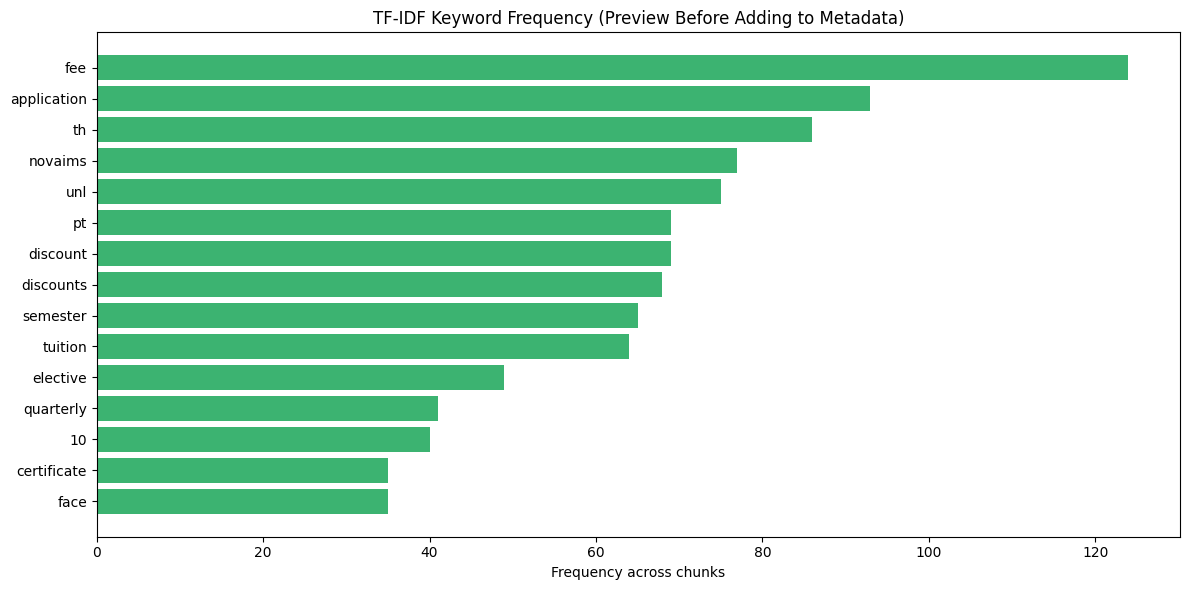

In [27]:
plot_top_tfidf_keywords_from_chunks(
    chunks=documents_chunked,
    top_n_per_chunk=3,
    plot_top_k=15,
    title="TF-IDF Keyword Frequency (Preview Before Adding to Metadata)"
)

In [28]:
from rank_bm25 import BM25Okapi
import matplotlib.pyplot as plt
from collections import Counter
import re
from typing import List
from langchain.schema import Document

def simple_tokenizer(text: str) -> List[str]:
    """Tokenizes input text using basic regex word splitting."""
    return re.findall(r"\b\w+\b", text.lower())

def plot_top_bm25_keywords_from_chunks(
    chunks: List[Document],
    top_n_per_chunk: int = 3,
    plot_top_k: int = 20,
    title: str = "Top BM25 Keywords Across Chunks"
):
    if not chunks:
        raise ValueError("❌ No chunks provided.")

    print(f"🧠 Tokenizing {len(chunks)} chunks...")

    # Step 1: Tokenize each chunk (BM25 expects list of tokenized documents)
    tokenized_corpus = [simple_tokenizer(doc.page_content) for doc in chunks]

    # Step 2: Fit BM25 model
    bm25 = BM25Okapi(tokenized_corpus)

    print("✅ BM25 model initialized.")

    # Step 3: For each chunk, get its own top-N keywords using BM25 relevance scores
    top_keywords = []

    for idx, tokens in enumerate(tokenized_corpus):
        scores = bm25.get_scores(tokens)
        keyword_scores = list(zip(tokens, scores))
        sorted_keywords = sorted(keyword_scores, key=lambda x: x[1], reverse=True)

        seen = set()
        chunk_top = []
        for word, score in sorted_keywords:
            if word not in seen:
                seen.add(word)
                chunk_top.append(word)
            if len(chunk_top) >= top_n_per_chunk:
                break

        top_keywords.extend(chunk_top)

    # Step 4: Count frequencies of top keywords
    keyword_counts = Counter(top_keywords)
    most_common = keyword_counts.most_common(plot_top_k)

    if not most_common:
        print("⚠️ No common keywords found to plot.")
        return

    # Step 5: Plot
    keywords, counts = zip(*most_common)

    plt.figure(figsize=(12, 6))
    plt.bar(keywords, counts, color="skyblue")
    plt.title(title)
    plt.ylabel("Frequency across chunks")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



🧠 Tokenizing 1017 chunks...
✅ BM25 model initialized.


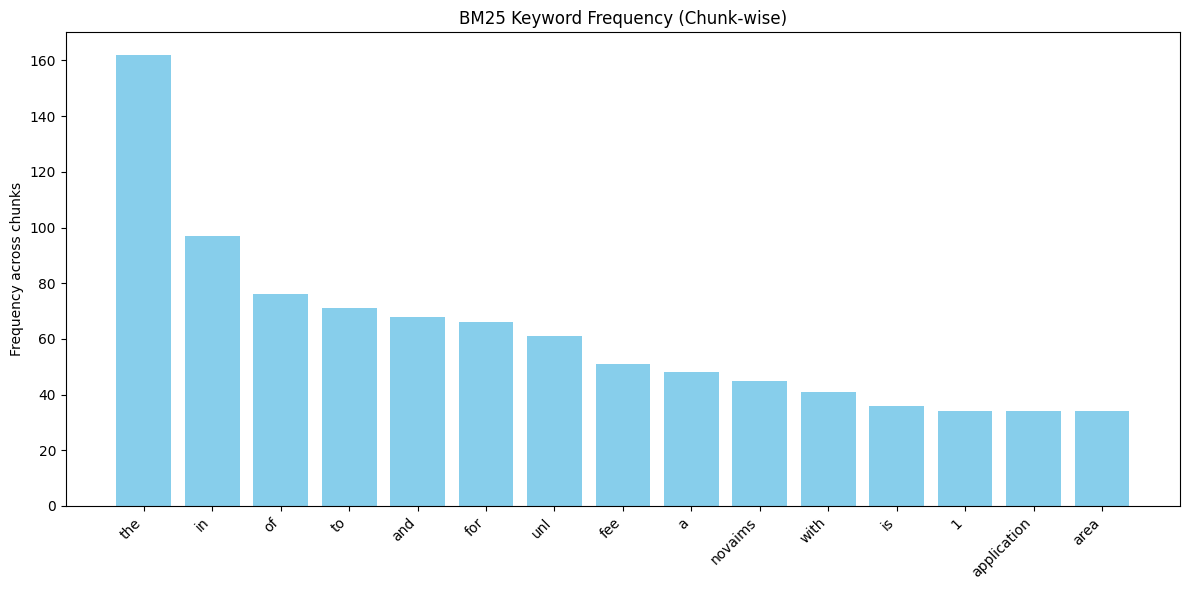

In [29]:
plot_top_bm25_keywords_from_chunks(
    chunks=documents_chunked,
    top_n_per_chunk=3,
    plot_top_k=15,
    title="BM25 Keyword Frequency (Chunk-wise)"
)

# Cleaning the chunks to effectively extract relevant keywords from each chunk

In [45]:
import regex as re  # not the standard 're'
from typing import List
from langchain.schema import Document
from nltk.corpus import stopwords
import nltk

nltk.download("stopwords")
BASE_STOPWORDS = set(stopwords.words("english"))

def clean_chunk_text(text: str) -> str:
    """
    Clean and normalize a single chunk of text, preserving names but removing numbers and punctuation.
    """

    # Create full stopwords once
    STOPWORDS = BASE_STOPWORDS.union({"novaims", "unl", "year", "ims", "nova", "portugal", "portuguese"})

    # Lowercase
    text = text.lower()

    # Remove anything that's not a letter or whitespace (no numbers, no punctuation)
    text = re.sub(r"[^\p{L}\s]", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize and remove stopwords and very short words
    tokens = [word for word in text.split() if word not in STOPWORDS and len(word) > 2]

    return " ".join(tokens)

def clean_documents_chunks(chunks: List[Document]) -> List[Document]:
    """
    Clean and normalize the text of each Document in a list.
    Returns a new list of cleaned Document objects with same metadata.
    """
    cleaned = []
    for doc in chunks:
        cleaned_text = clean_chunk_text(doc.page_content)
        cleaned.append(Document(page_content=cleaned_text, metadata=doc.metadata))
    return cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1176153\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
cleaned_documents_chunked = clean_documents_chunks(documents_chunked)


In [71]:
cleaned_documents_chunked

[Document(metadata={'source': 'bachelor_data-science_teaching-staff_text.txt', 'degree': 'bachelor', 'doc_type': 'teaching_staff', 'course_name': 'Data Science'}, page_content='teaching staff programs bachelor degrees data science teaching staff américo rio invited assistant professor americo rio ana cristina costa associate professor cristina artur varanda adjunct lecturer avaranda augusto santos assistant professor ajrsantos bruno damásio assistant professor bdamasio carina albuquerque assistant professor calbuquerque carolina maria shaul adjunct lecturer cshaul carolina santos maximiano adjunct lecturer cmaximiano carolina vasconcelos invited teaching assistant cvasconcelos catarina neves assistant professor cneves catarina palha invited teaching assistant cpalha dhruv akshay pandit invited teaching assistant dpandit diogo rasteiro research assistant drasteiro fernando bação full professor bacao filipe marques professor practice fjmarques gonçalo baptista professor practice gbaptist

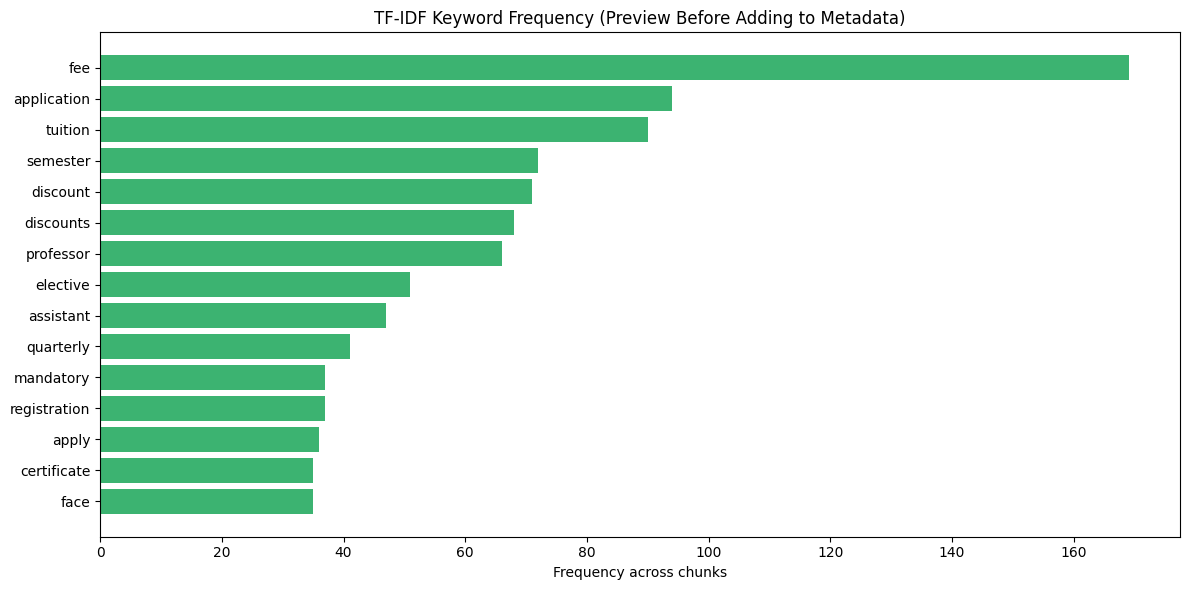

In [61]:
plot_top_tfidf_keywords_from_chunks(
    chunks=cleaned_documents_chunked,
    top_n_per_chunk=3,
    plot_top_k=15,
    title="TF-IDF Keyword Frequency (Preview Before Adding to Metadata)"
)

🧠 Tokenizing 1017 chunks...
✅ BM25 model initialized.


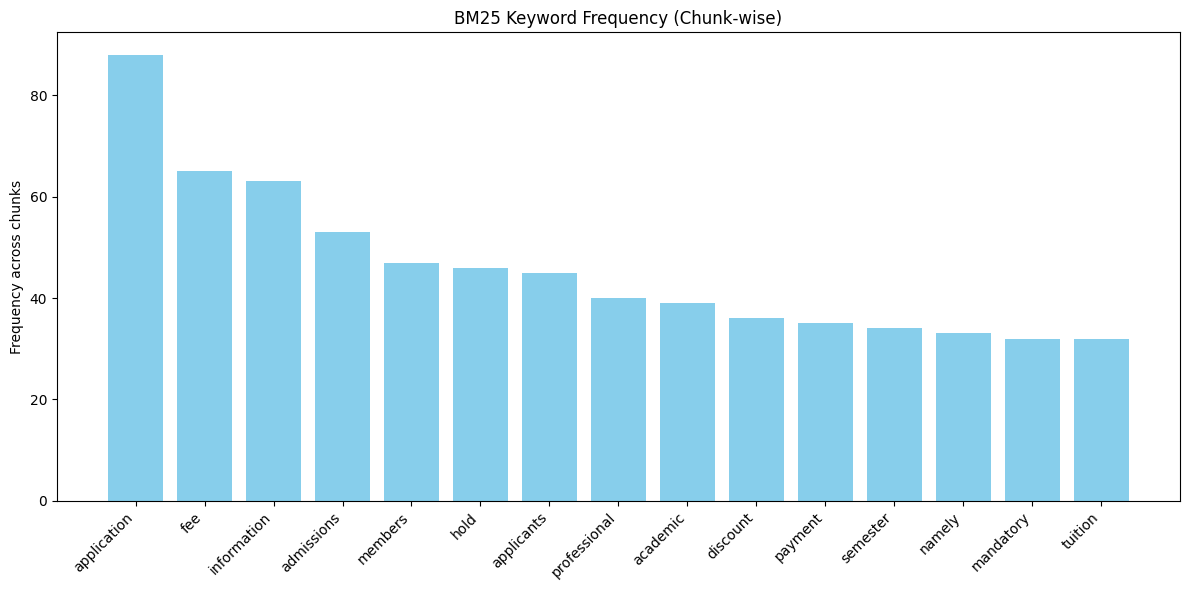

In [33]:
plot_top_bm25_keywords_from_chunks(
    chunks=cleaned_documents_chunked,
    top_n_per_chunk=3,
    plot_top_k=15,
    title="BM25 Keyword Frequency (Chunk-wise)"
)

# Creating the extracting functions:

## TF-IDF

In [46]:
from typing import List
from langchain.schema import Document
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def extract_top_keywords_tfidf(chunks: List[Document], top_n: int = 3) -> List[List[str]]:
    """
    Extract top N TF-IDF keywords from each chunk.
    Returns a list of top keywords for each chunk.
    """

    clean_chunks = clean_documents_chunks(chunks)

    # Extract text content from the chunks
    texts = [doc.page_content for doc in clean_chunks]

    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)

    feature_names = np.array(vectorizer.get_feature_names_out())

    top_keywords_per_chunk = []
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix[i].toarray().flatten()
        top_indices = row.argsort()[::-1][:top_n]
        top_keywords = feature_names[top_indices].tolist()
        top_keywords_per_chunk.append(top_keywords)

    return top_keywords_per_chunk




In [50]:
tfidf_keywords_list = extract_top_keywords_tfidf(documents_chunked, top_n=3)


In [8]:
tfidf_keywords_list

[['assistant', 'professor', 'invited'],
 ['assistant', 'adjunct', 'lecturer'],
 ['santos', 'lecturer', 'adjunct'],
 ['professor', 'assistant', 'adjunct'],
 ['professor', 'assistant', 'invited'],
 ['adjunct', 'lecturer', 'santos'],
 ['tiago', 'oliveira', 'assistant'],
 ['professor', 'assistant', 'invited'],
 ['assistant', 'professor', 'adjunct'],
 ['lecturer', 'adjunct', 'santos'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['elective', 'semester', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['elective', 'semester', 'web'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory', 'theoretical'],
 ['semester', 'mandatory

## BM25

In [47]:
from typing import List
from langchain.schema import Document
from rank_bm25 import BM25Okapi
import regex as re

def simple_tokenizer(text: str) -> List[str]:
    """Tokenizes input text using basic regex word splitting."""
    return re.findall(r"\b\w+\b", text.lower())

def extract_top_keywords_bm25(chunks: List[Document], top_n: int = 3) -> List[List[str]]:
    """
    Extract top N BM25 keywords from each chunk.
    Returns a list of top keywords for each chunk.
    """

    if not chunks:
        raise ValueError("❌ No chunks provided.")
    
    clean_chunks = clean_documents_chunks(chunks)

    # Tokenize each chunk
    tokenized_corpus = [simple_tokenizer(doc.page_content) for doc in clean_chunks]

    # Fit BM25 model
    bm25 = BM25Okapi(tokenized_corpus)

    # Extract top-N keywords per chunk
    top_keywords_per_chunk = []

    for tokens in tokenized_corpus:
        scores = bm25.get_scores(tokens)
        keyword_scores = list(zip(tokens, scores))
        sorted_keywords = sorted(keyword_scores, key=lambda x: x[1], reverse=True)

        seen = set()
        chunk_top = []
        for word, score in sorted_keywords:
            if word not in seen:
                seen.add(word)
                chunk_top.append(word)
            if len(chunk_top) >= top_n:
                break

        top_keywords_per_chunk.append(chunk_top)

    return top_keywords_per_chunk


In [51]:
# BM25 extraction
bm25_keywords_list = extract_top_keywords_bm25(documents_chunked, top_n=3)

In [12]:
bm25_keywords_list

[['teaching', 'bachelor', 'degrees'],
 ['bernardo', 'professor', 'ibernardo'],
 ['professor', 'santos', 'rpereira'],
 ['bachelor', 'teaching', 'degrees'],
 ['gbaptista', 'assistant', 'baptista'],
 ['marisa', 'adjunct', 'mnunes'],
 ['oliveira', 'invited', 'tiago'],
 ['teaching', 'bachelor', 'degrees'],
 ['assistant', 'neves', 'jneves'],
 ['professor', 'adjunct', 'pedro'],
 ['ects', 'aspects', 'systems'],
 ['algorithms', 'artificial', 'thinking'],
 ['preprocessing', 'mandatory', 'data'],
 ['storage', 'mandatory', 'data'],
 ['semester', 'legal', 'project'],
 ['digital', 'project', 'entrepreneurship'],
 ['semester', 'information', 'ects'],
 ['semester', 'personal', 'foundational'],
 ['mandatory', 'analysis', 'management'],
 ['mandatory', 'semester', 'optimization'],
 ['semester', 'information', 'business'],
 ['semester', 'elective', 'applied'],
 ['linear', 'semester', 'ects'],
 ['probability', 'mandatory', 'computation'],
 ['statistical', 'information', 'iii'],
 ['information', 'semester',

## KeyBERT

In [75]:
%pip install keybert

   ---------------------------------------- 0.0/41.4 kB ? eta -:--:--
   ---------------------------------------- 41.4/41.4 kB 1.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
from keybert import KeyBERT
from typing import List
from langchain.schema import Document  # if you're still using your Document chunks
from sentence_transformers import SentenceTransformer

# Load a strong default model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
kw_model = KeyBERT(model=embedding_model)

def extract_top_keywords_keybert(
    chunks: List[Document],
    top_n: int = 3,
    min_len: int = 1,
    max_len: int = 1,
    diversity: bool = False
) -> List[List[str]]:
    """
    Extract top N keywords per document chunk using KeyBERT.
    Returns a list of lists (keywords per chunk).
    """
    clean_chunks = clean_documents_chunks(chunks)
    results = []
    for doc in clean_chunks:
        # Extract keywords
        keywords = kw_model.extract_keywords(
            doc.page_content,
            keyphrase_ngram_range=(min_len, max_len),
            stop_words='english',
            use_maxsum=diversity,
            top_n=top_n
        )
        
        # keywords = list of (keyword, score) tuples; extract only keyword
        keywords_only = [kw for kw, score in keywords]
        results.append(keywords_only)

    return results


In [52]:
# Assuming you have cleaned your chunks already
keybert_keywords_list = extract_top_keywords_keybert(documents_chunked, top_n=3)



In [16]:
for idx, keywords in enumerate(keybert_keywords_list):
    print(f"Chunk {idx}: {keywords}")

Chunk 0: ['teaching', 'lecturer', 'assistant']
Chunk 1: ['lecturer', 'teaching', 'adjunct']
Chunk 2: ['lecturer', 'pereira', 'santos']
Chunk 3: ['lecturer', 'teaching', 'adjunct']
Chunk 4: ['lecturer', 'baptista', 'teaching']
Chunk 5: ['lecturer', 'adjunct', 'teaching']
Chunk 6: ['oliveira', 'lecturer', 'santos']
Chunk 7: ['lecturer', 'teaching', 'professor']
Chunk 8: ['lecturer', 'teaching', 'adjunct']
Chunk 9: ['lecturer', 'adjunct', 'teaching']
Chunk 10: ['semesters', 'semester', 'programming']
Chunk 11: ['semesters', 'semester', 'seminar']
Chunk 12: ['semesters', 'semester', 'tutor']
Chunk 13: ['semesters', 'semester', 'seminar']
Chunk 14: ['semesters', 'semester', 'teaching']
Chunk 15: ['semesters', 'semester', 'seminar']
Chunk 16: ['semesters', 'semester', 'seminar']
Chunk 17: ['semesters', 'semester', 'seminar']
Chunk 18: ['semesters', 'semester', 'tutor']
Chunk 19: ['semesters', 'semester', 'seminar']
Chunk 20: ['semesters', 'semester', 'seminar']
Chunk 21: ['semesters', 'semes

# Combining all extracted keywords from the different methods into the document chunks

In [53]:
from langchain.schema import Document

docs_to_save = []

for chunk, tfidf_kw, bm25_kw, keybert_kw in zip(documents_chunked, tfidf_keywords_list, bm25_keywords_list, keybert_keywords_list):
    metadata = chunk.metadata.copy()
    
    # Flatten all keyword lists
    tfidf_flattened = {f"keyword_tfidf_{i+1}": kw for i, kw in enumerate(tfidf_kw)}
    bm25_flattened = {f"keyword_bm25_{i+1}": kw for i, kw in enumerate(bm25_kw)}
    keybert_flattened = {f"keyword_keybert_{i+1}": kw for i, kw in enumerate(keybert_kw)}
    
    metadata.update({
        **tfidf_flattened,
        **bm25_flattened,
        **keybert_flattened,
    })
    
    doc = Document(
        page_content=chunk.page_content,
        metadata=metadata
    )
    docs_to_save.append(doc)


In [54]:
docs_to_save

[Document(metadata={'source': 'bachelor_data-science_teaching-staff_text.txt', 'degree': 'bachelor', 'doc_type': 'teaching_staff', 'course_name': 'Data Science', 'keyword_tfidf_1': 'assistant', 'keyword_tfidf_2': 'professor', 'keyword_tfidf_3': 'invited', 'keyword_bm25_1': 'teaching', 'keyword_bm25_2': 'bachelor', 'keyword_bm25_3': 'degrees', 'keyword_keybert_1': 'teaching', 'keyword_keybert_2': 'lecturer', 'keyword_keybert_3': 'assistant'}, page_content="Teaching Staff en Programs Bachelor's\nDegrees Data Science Teaching Staff Américo Rio Invited Assistant Professor\namerico.rio@novaims.unl.pt\n\nAna Cristina\nCosta Associate Professor\ncristina@novaims.unl.pt\n\nArtur Varanda\nAdjunct Lecturer\navaranda@novaims.unl.pt\n\nAugusto Santos\nAssistant Professor\najrsantos@novaims.unl.pt\n\nBruno Damásio\nAssistant Professor\nbdamasio@novaims.unl.pt\n\nCarina Albuquerque\nAssistant Professor\ncalbuquerque@novaims.unl.pt\n\nCarolina Maria\nShaul Adjunct Lecturer\ncshaul@novaims.unl.pt\n\nC

# Embedding and storing in ChromaDB

In [55]:
from langchain.embeddings import HuggingFaceEmbeddings
import torch

embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-base-en-v1.5",
    model_kwargs={"device": "cuda" if torch.cuda.is_available() else "cpu"},
    encode_kwargs={"normalize_embeddings": True}  # Important for BGE
)


In [56]:


# 1. Recreate Vectorstore with new documents and embeddings
vectorstore = Chroma.from_documents(
    documents=docs_to_save,     # your keyword-augmented documents
    embedding=embedding_model,  # your embedder
    persist_directory=r"..\..\vector database"
)
vectorstore.persist()



C:\Users\1176153\AppData\Local\Temp\ipykernel_14452\1678195172.py:7: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [6]:
# 2. Load it later for SelfQueryRetriever
vectorstore = Chroma(
    persist_directory=r"..\..\vector database",
    embedding_function=embedding_model,
    collection_name="thesis"   # default name if you didn't change it
)

C:\Users\1176153\AppData\Local\Temp\ipykernel_14452\2209631277.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


# Setting up the Seft Query Retriever

In [20]:
from langchain_community.llms import LlamaCpp
# Make sure the model path is correct for your system!
llm = LlamaCpp(
    model_path=r"C:\Users\1176153\.cache\huggingface\hub\models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF\snapshots\3a6fbf4a41a1d52e415a4958cde6856d34b2db93\mistral-7b-instruct-v0.2.Q4_K_M.gguf",
    temperature=0.1,
    max_tokens=2000,
    n_ctx=4096,
    top_p=1,
    streaming=False,  # Verbose is required to pass to the callback manager,
    n_batch=512,  
    verbose=True  
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from C:\Users\1176153\.cache\huggingface\hub\models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF\snapshots\3a6fbf4a41a1d52e415a4958cde6856d34b2db93\mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llam

In [21]:
from langchain.chains.query_constructor.ir import (
    Comparator,
    Comparison,
    Operation,
    Operator,
)
from langchain.llms import OpenAI  # Or any other LLM you prefer
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
import torch

# 2. Define your metadata field information
metadata_field_info = [
    {
        "name": "source",
        "description": "The file name of the document (string).",
        "type": "string",
    },
    {
        "name": "degree",
        "description": "The academic degree level. Possible values include 'bachelor', 'master', 'phd' (string).",
        "type": "string",
    },
    {
        "name": "doc_type",
        "description": "The type of document. Possible values include 'teaching_staff', 'course_description', 'research_paper' (string).",
        "type": "string",
    },
    {
        "name": "course_name",
        "description": "The name of the course (string).",
        "type": "string",
    },
    {
        "name": "keyword_tfidf_1",
        "description": "The top keyword extracted using TF-IDF (string).",
        "type": "string",
    },
    {
        "name": "keyword_tfidf_2",
        "description": "The second top keyword extracted using TF-IDF (string).",
        "type": "string",
    },
    {
        "name": "keyword_tfidf_3",
        "description": "The third top keyword extracted using TF-IDF (string).",
        "type": "string",
    },
    {
        "name": "keyword_bm25_1",
        "description": "The top keyword extracted using BM25 (string).",
        "type": "string",
    },
    {
        "name": "keyword_bm25_2",
        "description": "The second top keyword extracted using BM25 (string).",
        "type": "string",
    },
    {
        "name": "keyword_bm25_3",
        "description": "The third top keyword extracted using BM25 (string).",
        "type": "string",
    },
    {
        "name": "keyword_keybert_1",
        "description": "The top keyword extracted using KeyBERT (string).",
        "type": "string",
    },
    {
        "name": "keyword_keybert_2",
        "description": "The second top keyword extracted using KeyBERT (string).",
        "type": "string",
    },
    {
        "name": "keyword_keybert_3",
        "description": "The third top keyword extracted using KeyBERT (string).",
        "type": "string",
    },
]

In [22]:
# 4. Define your custom prompt template
prompt_template = """You are a query parser that takes a natural language query and a description of available metadata fields and their types. Your goal is to output a JSON object representing a structured query.

The structured query should have two keys: "query" and "filter".

- The "query" value should be the parts of the natural language query that are relevant for semantic search against the document content.
- The "filter" value should be a string representing a filter expression based on the metadata fields. The filter expression should use the following format:

    - For equality: eq("field_name", "value")
    - For AND: and(condition1, condition2, ...)
    - For OR: or(condition1, condition2, ...)

Here are the available metadata fields and their descriptions:
{metadata_field_info}

For the query: "{query}", please generate a JSON object with the "query" and "filter" as described. If no filter is needed, the "filter" value should be an empty string.

Example:
Query: "Show me bachelor level courses about artificial intelligence"
Output:
```json
{{
    "query": "artificial intelligence",
    "filter": "and(eq(\\"degree\\", \\"bachelor\\"), eq(\\"doc_type\\", \\"course_description\\"))"
}}
Query: "Find teaching staff"
Output:
```json
{{
    "query": "teaching staff",
    "filter": "eq(\\"doc_type\\", \\"teaching_staff\\")"
}}
Query: "What are the keywords for the Data Science course?"
Output:
```json
{{
    "query": "keywords",
    "filter": "eq(\\"course_name\\", \\"Data Science\\")"
}}
"""

In [23]:
retriever = SelfQueryRetriever.from_llm(
    llm=llm,
    vectorstore=vectorstore,
    document_contents="Content of teaching staff and program descriptions",
    metadata_field_info=metadata_field_info,
    verbose=True,
)



In [24]:
results = retriever.invoke("Show teaching staff for the Data Science bachelor program", verbose=True)
results

llama_perf_context_print:        load time =  193008.62 ms
llama_perf_context_print: prompt eval time =  193008.08 ms /  1483 tokens (  130.15 ms per token,     7.68 tokens per second)
llama_perf_context_print:        eval time =   16808.42 ms /    49 runs   (  343.03 ms per token,     2.92 tokens per second)
llama_perf_context_print:       total time =  209848.71 ms /  1532 tokens


OutputParserException: Parsing text
```json
{
    "query": "",
    "filter": "and(eq(\"degree\", \"bachelor\"), eq(\"doc_type\", \"teaching_staff\"))))"
}
```
 raised following error:
Unexpected token Token('RPAR', ')') at line 1, column 64.
Expected one of: 
	* $END

For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

# Test

In [57]:
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
import torch

# Your LlamaCpp LLM
from langchain_community.llms import LlamaCpp

llm = LlamaCpp(
    model_path=r"C:\Users\1176153\.cache\huggingface\hub\models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF\snapshots\3a6fbf4a41a1d52e415a4958cde6856d34b2db93\mistral-7b-instruct-v0.2.Q4_K_M.gguf",
    temperature=0.1,
    max_tokens=2000,
    n_ctx=4096,
    top_p=1,
    streaming=False,
    n_batch=512,
    verbose=True
)


llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from C:\Users\1176153\.cache\huggingface\hub\models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF\snapshots\3a6fbf4a41a1d52e415a4958cde6856d34b2db93\mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llam

In [58]:
# Convert your metadata into AttributeInfo objects
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The file name of the document",
        type="string",
    ),
    AttributeInfo(
        name="degree",
        description="The academic degree level",
        type="string",
    ),
    AttributeInfo(
        name="doc_type",
        description="The type of document",
        type="string",
    ),
    AttributeInfo(
        name="course_name",
        description="The name of the course",
        type="string",
    ),
    # Keywords (tfidf, bm25, keybert)
    AttributeInfo(name="keyword_tfidf_1", description="Top TF-IDF keyword", type="string"),
    AttributeInfo(name="keyword_tfidf_2", description="Second TF-IDF keyword", type="string"),
    AttributeInfo(name="keyword_tfidf_3", description="Third TF-IDF keyword", type="string"),
    AttributeInfo(name="keyword_bm25_1", description="Top BM25 keyword", type="string"),
    AttributeInfo(name="keyword_bm25_2", description="Second BM25 keyword", type="string"),
    AttributeInfo(name="keyword_bm25_3", description="Third BM25 keyword", type="string"),
    AttributeInfo(name="keyword_keybert_1", description="Top KeyBERT keyword", type="string"),
    AttributeInfo(name="keyword_keybert_2", description="Second KeyBERT keyword", type="string"),
    AttributeInfo(name="keyword_keybert_3", description="Third KeyBERT keyword", type="string"),
]

In [59]:
vector_store = Chroma(
    persist_directory="./chroma_langchain_db",
    embedding_function=embedding_model,
    collection_name="test"   # default name if you didn't change it
)

In [60]:
# Define the document content field
document_content_description = "Content of the university course descriptions and classes."

# Build SelfQueryRetriever
retriever = SelfQueryRetriever.from_llm(
    llm=llm,
    vectorstore=vector_store,
    document_contents=document_content_description,
    metadata_field_info=metadata_field_info,
    enable_limit=False,  # Optional: allows specifying "return only top 3 results", etc.
)

In [61]:
# OPTIONAL: Create a QA chain using your retriever if you want
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

In [62]:
response = qa_chain.run("course_description CONTAINS 'Artificial Intelligence' AND level = 'master'")

print(response)

llama_perf_context_print:        load time =  179556.32 ms
llama_perf_context_print: prompt eval time =  179555.40 ms /  1384 tokens (  129.74 ms per token,     7.71 tokens per second)
llama_perf_context_print:        eval time =   18026.04 ms /    46 runs   (  391.87 ms per token,     2.55 tokens per second)
llama_perf_context_print:       total time =  197616.97 ms /  1430 tokens


OutputParserException: Parsing text
```json
{
    "query": "",
    "filter": "and(contains(course_description, \"Artificial Intelligence\")), eq(level, \"master\"))"
}
```
 raised following error:
Unexpected token Token('COMMA', ',') at line 1, column 32.
Expected one of: 
	* LPAR
Previous tokens: [Token('CNAME', 'course_description')]

For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 